In [1]:
from __future__ import print_function, division
import os, bz2, json, time
from datetime import timedelta

import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


import sys
sys.path.insert(0, '../')
from pyhip import HIP

In [2]:
dataset_path = "../data/active-dataset.json.bz2"
vidsOrder_path = "../data/active-dataset-vids-order.json"

output_folder = "../output/active_output"

In [3]:
active_hip_res = {}
for (dirpath, dirnames, dirfiles) in os.walk(output_folder):
    # trivial loop
    for output_json in dirfiles:
        res_path = os.path.join(output_folder, output_json)
        with open(res_path, "r") as infile:
            active_hip_res = {**active_hip_res, **json.loads(infile.readline())}
print("#videos evaluated on HIP:",len(active_hip_res))
vids = list(active_hip_res.keys())
print(vids[0]+":" ,active_hip_res[vids[0]])

#videos evaluated on HIP: 800
00-6OyXVA0M: {'category': 'Entertainment', 'hipParams': [436.91249394708854, 555.6561615624704, 10.455729533740234, 0.009096105449466808, 0.0, 0.0, 1.0725620759963126, 468.6157715366156], 'predictViewcount': [110975.7734625605, 618748.4265383878, 257258.06635510508, 123137.11162190908, 84790.28534167168, 100109.41854426476, 169304.15340230704, 329963.14732377225, 155581.31787920068, 77810.07187921746, 38032.524295931486, 32283.065155570424, 28398.79686321676, 21145.414434624883, 20654.701124138963, 20621.502881049113, 18434.694449525592, 11733.062820447245, 11716.589618170869, 13026.212637938346, 7434.950184137273, 7930.50931668581, 8400.947888275772, 6685.1245080265135, 7442.868842595107, 7057.220050042333, 3972.742282472278, 5511.717986450817, 4305.096876507967, 728.1653488780993, 1360.0000751826283, 2276.5705977673083, 3649.3168541160903, 1557.6248302094411, 3163.7654994538293, 3272.4257848682837, 1532.1270068003046, 1851.3030125603054, 1872.89623695679

### read results from file and evaluate
+ train, test done by hip-on-ACTIVE.py

In [4]:
def pop_perc_at(days, viewcounts, vids, num_train):
    """ compute popularity percentile for a series at several evaluation days
    :param days: list, time points to chop and compute popularity percentile 
    :param viewcounts: list, viewcount history for multiple videos
    :return: list of dataframe
    """
    viewcount_eval = []
    for i in range(len(viewcounts)):
        viewcount_accu = [np.sum(viewcounts[i][:num_train+day]) for day in days]
        viewcount_eval.append(viewcount_accu)
        
    df_viewcount_eval = pd.DataFrame(viewcount_eval, columns =days, index = vids)
    
    pop_perc_col = np.linspace(0, 1, len(df_viewcount_eval[days[0]]))
    pop_percs = []
    for day in days:
        df_viewcount_sort = df_viewcount_eval.loc[:,[day]].sort_values(by=[day], inplace=False)
        df_viewcount_sort[day] = pop_perc_col
        pop_percs.append(df_viewcount_sort)
    return pop_percs

In [5]:
def perc_error(days, percs_pred, percs_gt):
    """ compute HIP prediction percentile error at different days
    """
    perc_error = []
    for i, day in enumerate(days):
        error = []
        perc_pred = percs_pred[i]
        perc_gt = percs_gt[i]
        for ind in perc_pred.index:
            error.append(np.abs(perc_pred.loc[ind, day]-perc_gt.loc[ind, day]))
        perc_error.append(np.mean(error))
    return perc_error

def perc_error_cate(days, percs_pred, percs_gt, dataset):
    """ compute HIP prediction percentile error at different days,
        and break down to different categories
    """
    perc_error = []
    for i, day in enumerate(days):
        error = {}
        perc_pred = percs_pred[i]
        perc_gt = percs_gt[i]
        for ind in perc_pred.index:
            if dataset[ind]["category"] in error:
                error[dataset[ind]["category"]].append(np.abs(perc_pred.loc[ind, day]-perc_gt.loc[ind, day]))
            else:
                error[dataset[ind]["category"]] = [np.abs(perc_pred.loc[ind, day]-perc_gt.loc[ind, day])]                
        perc_error.append({cate: np.mean(error[cate]) for cate in error.keys()})
    return perc_error

In [6]:
# copy train params
num_train = 90
num_test = 30
num_initialization = 25

In [7]:
days = [15,30]
viewcounts_pred = [active_hip_res[vid]["predictViewcount"] for vid in vids]
viewcounts_gt = [active_hip_res[vid]["dailyViewcount"] for vid in vids]

pop_percs_pred = pop_perc_at(days, viewcounts_pred, vids, num_train)
pop_percs_gt = pop_perc_at(days, viewcounts_gt, vids, num_train)

In [8]:
mAPE = perc_error(days, pop_percs_pred, pop_percs_gt)
print("Mean absolute percentile error at {}:{}".format(days, mAPE))
mAPE_cate = perc_error_cate(days, pop_percs_pred, pop_percs_gt, active_hip_res)
print("Mean absolute percentile error at {}:\n{}".format(days, mAPE_cate))

Mean absolute percentile error at [15, 30]:[0.0064267834793491855, 0.009130162703379225]
Mean absolute percentile error at [15, 30]:
[{'Education': 0.002145539066690507, 'Music': 0.005789256274776971, 'People & Blogs': 0.008400330922127238, 'News & Politics': 0.005844935034772846, 'Nonprofits & Activism': 0.005632040050062576, 'Film & Animation': 0.01243742177722152, 'Entertainment': 0.006219896082223988, 'Sports': 0.007008760951188983, 'Howto & Style': 0.00346587080003852, 'Travel & Events': 0.0018773466833541946, 'Gaming': 0.005466391813296036, 'Autos & Vehicles': 0.006257822277847301, 'Comedy': 0.005666173626123557, 'Science & Technology': 0.006492490613266568, 'Pets & Animals': 0.006883604505632024, 'Shows': 0.0012515644555695093}, {'Education': 0.00366529590559628, 'Music': 0.008711628451820934, 'People & Blogs': 0.010511020131096078, 'News & Politics': 0.008206133956104925, 'Nonprofits & Activism': 0.006257822277847301, 'Film & Animation': 0.021276595744680847, 'Entertainment': 0

## analysis and visualization

<BarContainer object of 2 artists>

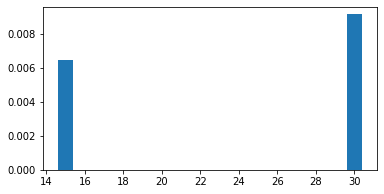

In [9]:
figure1 = plt.figure(figsize=(6,3))
ax1 = figure1.add_subplot(111)
ax1.bar(days, mAPE)

<BarContainer object of 16 artists>

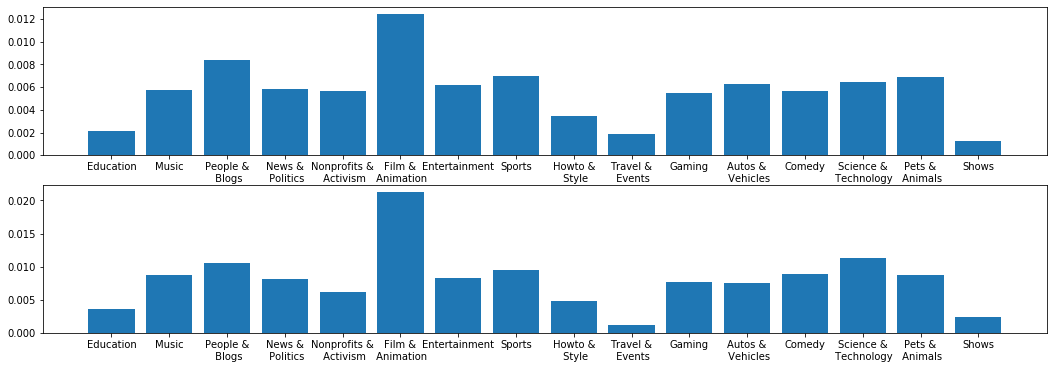

In [10]:
categories = ['Education', 'Music', 'People & Blogs', 'News & Politics', 'Nonprofits & Activism',\
              'Film & Animation', 'Entertainment', 'Sports', 'Howto & Style', 'Travel & Events',\
              'Gaming', 'Autos & Vehicles', 'Comedy', 'Science & Technology', 'Pets & Animals', 'Shows']
figure2 = plt.figure(figsize=(18,6))
ax2 = figure2.add_subplot(211)
ax2.bar([cate.replace("&","&\n") for cate in categories], [mAPE_cate[0][cate] for cate in categories])
ax2 = figure2.add_subplot(212)
ax2.bar([cate.replace("&","&\n") for cate in categories], [mAPE_cate[1][cate] for cate in categories])